In [1]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO

In [82]:
# SET SEASON, WEEK, TEAM to be plotted
SEASON = 2022
WEEKS = [6]
TEAM = 'SF'

In [83]:
# get team info (colors, URLS, abbr., etc.)
df_teams_info = pd.read_csv("./data/team_logos.csv")

# get pbp_participation
df_par = pd.read_csv(f"https://github.com/nflverse/nflverse-data/releases/download/pbp_participation/pbp_participation_{SEASON}.csv")

# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam',
        'defteam',
        'game_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards'] #'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']

df_pbp = nfl.import_pbp_data(years=[SEASON], columns=cols, downcast=True, cache=False)

2022 done.
Downcasting floats.


In [84]:
def get_offensive_drives(df=df_pbp, team=TEAM, weeks=WEEKS):
    """
     filter play-by-play data by team, week, and notnull() valued downs
    """
    conditional_team = (df['posteam'] == team)
    conditional_week = (df['week'].isin(weeks))
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]


def print_epa_stats(epa_stats):
    print(f"min epa: {epa_stats['minEPA']}")
    print(f"max epa: {epa_stats['maxEPA']}")
    print(f"epa range: {epa_stats['rangeEPA']}")
    print(f"epa mean: {epa_stats['meanEPA']}")
    print(f"epa median: {epa_stats['medianEPA']}")
    print(f"epa mean-median difference: {epa_stats['meanmedian_diffEPA']}")
    print(f"epa mean+median sum: {epa_stats['meanmedian_sumEPA']}")
    print(f"positive/negative EPA ratio: {epa_stats['posnegratioEPA']}")
    print(f"standard deviation: {epa_stats['stdEPA']}")

#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' min epa: {epa_stats['minEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' max epa: {epa_stats['maxEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa range: {epa_stats['rangeEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa mean: {epa_stats['meanEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa median: {epa_stats['medianEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa mean-median difference: {epa_stats['meanmedian_diffEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa mean+median sum: {epa_stats['meanmedian_sumEPA']}")
#     print(f"{SEASON} WEEK {WEEK} {TEAM}s' epa standard deviation: {epa_stats['stdEPA']}")


def get_epa_stats(df=df_pbp, team=TEAM, weeks=[WEEK]):
    df = get_offensive_drives(df,team, weeks)
    epa_stats = {'minEPA':df.epa.min(),
                 'maxEPA':df.epa.max(),
                 'rangeEPA':df.epa.max() - df.epa.min(),
                 'meanEPA':df.epa.mean(),
                 'medianEPA':df.epa.median(),
                 'meanmedian_diffEPA':df.epa.mean() - df.epa.median(),
                 'meanmedian_sumEPA':df.epa.mean() + df.epa.median(),
                 'posnegratioEPA':sum(df.epa > 0)/sum(df.epa < 0),
                 'stdEPA':df.epa.std()}
    return epa_stats


def getImage(df=df_teams_info, team=TEAM):
    try:
        img = Image.open(f'./imgs/{team}.png')
    except:
        logoURL = df[df.team_abbr == team].team_logo_espn.tolist()[0]
        # print(logoURL)
        response = requests.get(logoURL)
        # print(response)
        img = Image.open(BytesIO(response.content))
        img.save(fp=f"./imgs/{team}.png")
    return img

In [85]:
df_teamEPA = get_offensive_drives()
df_teamEPA

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,yards_gained,...,posteam,defteam,game_seconds_remaining,game_half,fixed_drive_result,play_type,penalty_team,penalty_type,penalty_yards,season
16177,2022_06_SF_ATL,355.0,-0.260047,REG,6,2.0,5.0,1.0,10.0,3.0,...,SF,ATL,3219.0,Half1,Punt,run,None,None,NaN,2022
16178,2022_06_SF_ATL,376.0,-0.308281,REG,6,2.0,5.0,2.0,7.0,3.0,...,SF,ATL,3182.0,Half1,Punt,run,None,None,NaN,2022
16179,2022_06_SF_ATL,397.0,-1.566656,REG,6,2.0,5.0,3.0,4.0,0.0,...,SF,ATL,3139.0,Half1,Punt,pass,None,None,NaN,2022
16180,2022_06_SF_ATL,419.0,-0.992562,REG,6,2.0,5.0,4.0,4.0,0.0,...,SF,ATL,3132.0,Half1,Punt,punt,None,None,NaN,2022
16189,2022_06_SF_ATL,636.0,0.334320,REG,6,4.0,8.0,1.0,10.0,7.0,...,SF,ATL,2879.0,Half1,Opp touchdown,pass,None,None,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16308,2022_06_SF_ATL,3339.0,-3.603827,REG,6,16.0,46.0,4.0,2.0,0.0,...,SF,ATL,158.0,Half2,Turnover on downs,pass,None,None,NaN,2022
16320,2022_06_SF_ATL,3528.0,-0.181513,REG,6,18.0,49.0,1.0,10.0,5.0,...,SF,ATL,64.0,Half2,End of half,pass,None,None,NaN,2022
16321,2022_06_SF_ATL,3552.0,0.121672,REG,6,18.0,49.0,2.0,5.0,10.0,...,SF,ATL,47.0,Half2,End of half,pass,None,None,NaN,2022
16322,2022_06_SF_ATL,3576.0,0.446953,REG,6,18.0,50.0,1.0,10.0,21.0,...,SF,ATL,27.0,Half2,End of half,pass,None,None,NaN,2022


In [86]:
epa_stats = get_epa_stats(df_pbp, TEAM, WEEKS)
print_epa_stats(epa_stats)
    

min epa: -7.242469787597656
max epa: 2.695502281188965
epa range: 9.937972068786621
epa mean: -0.1616632491350174
epa median: 0.041697632521390915
epa mean-median difference: -0.2033608853816986
epa mean+median sum: -0.11996561288833618
positive/negative EPA ratio: 1.03125
standard deviation: 1.4988569021224976


In [87]:
# FONT FAMILY
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')
# assign name of font family
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#efefef"#"#DBDBDB" #"#808B96" straw"#e0dfd5"
text_color = "black"
title_color = "#706f6f"
axs_title_color = "black"#"#ff1d15" #"#706f6f"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#706f6f"
axs_label_color = "black"#"#FFC53A"
credits_text_color = text_color
spines_color = "black"
grid_color = "black"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "black"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#d166ff","white","#8ff856"]#["#313131","#a0a0a0","white"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#191102"
playlist_text_color = text_color
penalty_color = "#faff00"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"

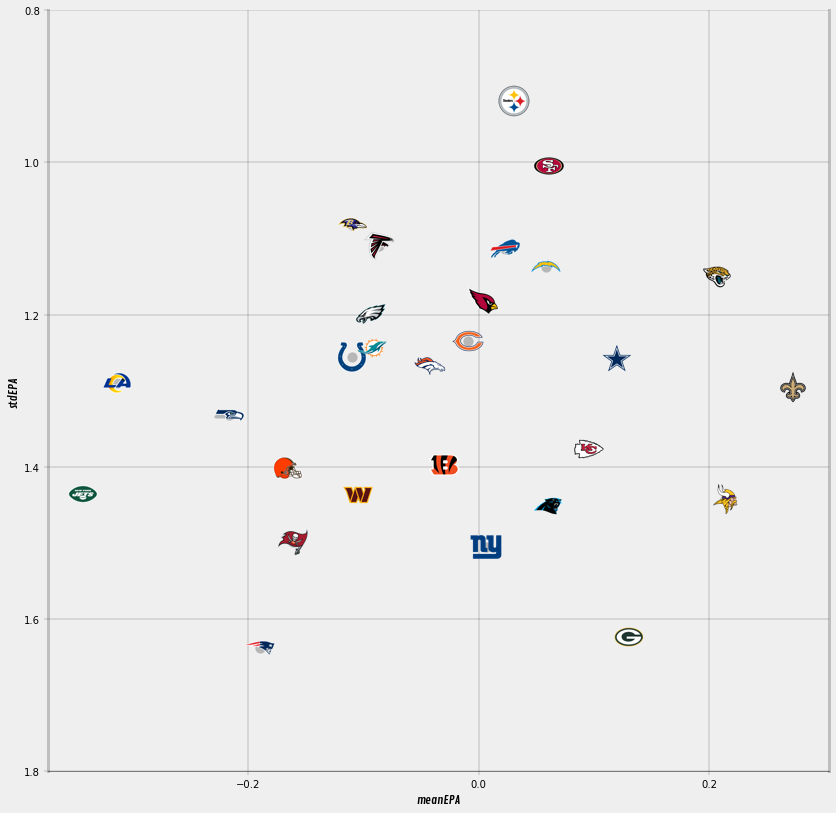

In [93]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x_vals = 'meanEPA'
y_vals = 'stdEPA'

cmap = matplotlib.cm.get_cmap(color_map)
# norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
# plot figure, axs
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(background)
ax.set_facecolor(background)
#  set properties of axis
ax.patch.set_facecolor(background)
ax.grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
ax.set_title("",pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
# ax.set_xlim(0,100)
ax.set_xlabel(f"{x_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.set_ylabel(f"{y_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.tick_params(axis="both",length=4, width=0.2, color=grid_color)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

spines = ["top", "right", "bottom", "left"]
for s in spines:
    if s in ["top"]:
        ax.spines[s].set_visible(False)
    elif s in ["left", "right"]:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_linewidth(3)
        ax.spines[s].set_alpha(.2)
    else:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_alpha(.6)

weeks = [6]
for week in weeks:
    teams = df_pbp[df_pbp.week == week].posteam.unique()
    for team in teams:
        if team != None:
            x,y = epa_stats[x_vals], epa_stats[y_vals]
            epa_stats = get_epa_stats(df_pbp, team, [week])
            img = getImage(team=team)
            img.thumbnail((32, 32))
            imagebox = OffsetImage(img)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, [x, y], frameon=False)
            ax.add_artist(ab)
            ax.scatter(epa_stats[x_vals],epa_stats[y_vals], color="grey",edgecolors='white',s=120, alpha=0.5,lw=1)
                
ax.set_ylim(1.8,0.8)
plt.show()
            


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f67dc6b7eb0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f67dc6b7f40>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f67dc6bee20>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f67dc6455e0>}

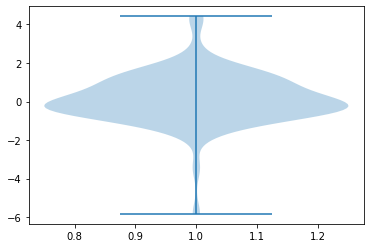

In [78]:
plt.violinplot(df_teamEPA.epa)

-8.076691 3.02111
-9.949822 5.9553237


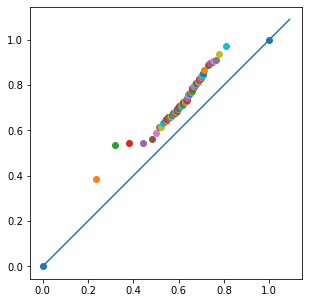

In [135]:
def normEPA_btwn0and1(df):
    min_epa = df.epa.min()
    max_epa = df.epa.max()
    print(min_epa,max_epa)
    return (df.epa-min_epa) / (max_epa - min_epa)

df_week = get_offensive_drives(df=df_pbp, team='LA', weeks=[6])
df_notweek = get_offensive_drives(df=df_pbp, team='LA', weeks=[1,2,3,4,5])
week_epa_norm01 = normEPA_btwn0and1(df_week)
notweek_epa_norm01 = normEPA_btwn0and1(df_notweek)





fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

for x_quantile in np.arange(0.0,1.01,0.01):
    pass
    # print(np.quantile(notweek_epa_norm01, x_quantile), np.quantile(week_epa_norm01, x_quantile))
    # ax.scatter(x=np.quantile(df_notweek.epa, x_quantile),y=np.quantile(df_week.epa, x_quantile))
    ax.scatter(x=np.quantile(notweek_epa_norm01, x_quantile),y=np.quantile(week_epa_norm01, x_quantile))
ax.plot(np.arange(0.0,1.1,0.01),np.arange(0.0,1.1,0.01))
# ax.plot(np.arange(-10.0,6.0,0.5),np.arange(-10.0,6.0,0.5))

plt.show()